<a href="https://colab.research.google.com/github/NJain121442/course2020/blob/master/Fruits_unsupervised_clustering_conv2_1August.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [418]:
import torch.nn as nn
import glob
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torchvision import datasets, transforms
import numpy as np
from torchsummary import summary 
import matplotlib.image as mpimg
import torchvision

In [419]:
!unzip /content/Fruits.zip -d /content/

Archive:  /content/Fruits.zip
replace /content/Fruits/1.jfif? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/Fruits/1.jfif  
  inflating: /content/Fruits/10.jfif  
  inflating: /content/Fruits/100.jfif  
  inflating: /content/Fruits/101.jfif  
  inflating: /content/Fruits/102.jfif  
  inflating: /content/Fruits/103.jfif  
  inflating: /content/Fruits/104.jfif  
  inflating: /content/Fruits/105.jfif  
  inflating: /content/Fruits/106.jfif  
  inflating: /content/Fruits/107.jfif  
  inflating: /content/Fruits/108.jfif  
  inflating: /content/Fruits/109.jfif  
  inflating: /content/Fruits/11.jfif  
  inflating: /content/Fruits/110.jfif  
  inflating: /content/Fruits/111.jfif  
  inflating: /content/Fruits/112.jfif  
  inflating: /content/Fruits/113.jfif  
  inflating: /content/Fruits/114.jfif  
  inflating: /content/Fruits/115.jfif  
  inflating: /content/Fruits/116.jfif  
  inflating: /content/Fruits/117.jfif  
  inflating: /content/Fruits/118.jfif  
  inflating: /content/

In [420]:
Data_path = "/content/Fruits/"

In [421]:
filelist = glob.glob(Data_path+'/*.jfif')

In [422]:
filelist[2]

'/content/Fruits/63.jfif'

In [423]:
len(filelist)

126

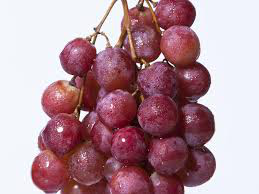

In [424]:
from PIL import Image

Image.open(filelist[125])

(168, 300, 3)


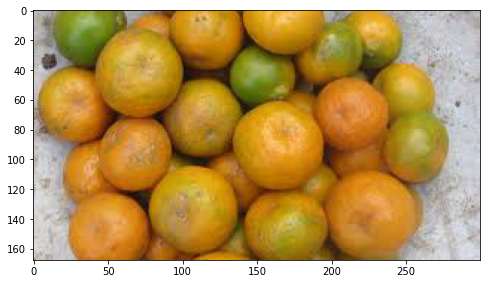

In [425]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(filelist[99])
print(img.shape)
plt.imshow(img)


Original Dimensions :  (167, 302, 3)


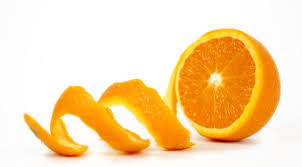

Resized Dimensions :  (504, 504, 3)


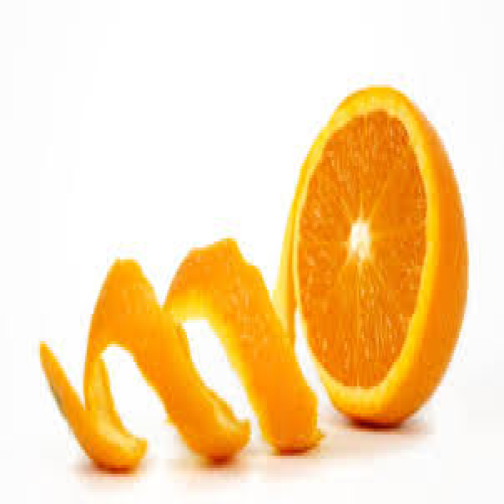

In [426]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread(filelist[9])
print('Original Dimensions : ',img.shape)
cv2_imshow(img)
dim = (504,504)
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
print('Resized Dimensions : ',resized.shape)
cv2_imshow(resized)


Lets Resize all images to same size

In [427]:
class CustomDataset(Dataset):
  def __init__(self,path,new_size = 226):
    self.filelist = glob.glob(path+'/*.jfif')
    self.new_size = new_size

  def __len__(self):
    return len(self.filelist)

  def __getitem__(self, idx):
    temp_filepath = self.filelist[idx]
    temp_image = cv2.imread(temp_filepath)
    #print('Original Dimensions : ',temp_image.shape)
    #cv2_imshow(temp_image)
    dim = (504,504)
    temp_image = cv2.resize(temp_image, dim, interpolation = cv2.INTER_AREA)
    #print('Resized Dimensions : ',temp_image.shape)
    #cv2_imshow(temp_image)
    #print(temp_image.shape)
    temp_image = temp_image/255
    #temp_image = torch.from_numpy(temp_image)
    temp_image = torch.Tensor(temp_image)
    temp_image = torch.reshape(temp_image,(3,504,504))
    #temp_image = torch.TensorType(temp_image,torch.FloatTensor)
    #print(temp_image)
    return temp_image

In [428]:
Data = CustomDataset(Data_path)
Data[2].shape

torch.Size([3, 504, 504])

**Lets write the first Auto encoder **

In [429]:
class Conv2d_Autoencoder(nn.Module):
    def __init__(self):
        super(Conv2d_Autoencoder, self).__init__()
        latent_dim = 1024
 
        # encoder layers
        self.enc1 = nn.Conv2d(3,32,kernel_size=3,stride=3)
        self.enc2 = nn.Conv2d(32,64,kernel_size=3,stride=3)
        self.enc3 = nn.Conv2d(64,128,kernel_size=2,stride=3)
        self.pool = nn.MaxPool2d(2,2,return_indices=True)
        self.FC1 = nn.Linear(3200,latent_dim)
        
        # decoder layers
        self.FC2 = nn.Linear(latent_dim,3200)
        self.dec1 = nn.ConvTranspose2d(128,64, kernel_size=2, stride=3)  
        self.dec2 = nn.ConvTranspose2d(64,32, kernel_size=3, stride=3)
        self.dec3 = nn.ConvTranspose2d(32,3, kernel_size=3, stride=3)
        self.unpool = nn.MaxUnpool2d(2,2,padding=0)

 
    def forward(self, x):
        # encode
        x = F.relu(self.enc1(x)) # output will be 168x168x32
        #print(x.shape)
        x,indices1 = self.pool(x) #output will be 84x84x32
        #print(x.shape)
        x = F.relu(self.enc2(x)) #output will be 28x28x64
        #print(x.shape)
        x,indices2 = self.pool(x)   # output will be 14x14x64
        #print(x.shape)
        x = F.relu(self.enc3(x)) #output will be 5x5x128 
        #print(x.shape)
        x = x.view(-1,3200) # after flattening the size will be 3200
        #print(x.shape)
        x = F.relu(self.FC1(x)) # the latent space representation
        #print(x.shape)
        
        # decode
        x = F.relu(self.FC2(x)) #size back to 3200
        #print(x.shape)
        x = torch.reshape(x,(1,128,5,5))
        #print(x.shape)
        x = F.relu(self.dec1(x)) # ouput will be 14x14x62
        #print(x.shape)
        x = self.unpool(x,indices2) #output will be 28x28x64
        #print(x.shape)
        x = F.relu(self.dec2(x)) # output will be 84x84x32
        #print(x.shape)
        #print("indices_shape:",indices.shape)
        x = self.unpool(x,indices1) #output will be 168x168x32
        #print(x.shape)
        x = self.dec3(x) # output will be 504x504x3
        #x = torch.sigmoid(self.dec3(x)) # output will be 504x504x3
        #print(x.shape)
        return x
 

In [430]:
net = Conv2d_Autoencoder()
print(net)
#summary(net,(3,504,504))

Conv2d_Autoencoder(
  (enc1): Conv2d(3, 32, kernel_size=(3, 3), stride=(3, 3))
  (enc2): Conv2d(32, 64, kernel_size=(3, 3), stride=(3, 3))
  (enc3): Conv2d(64, 128, kernel_size=(2, 2), stride=(3, 3))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (FC1): Linear(in_features=3200, out_features=1024, bias=True)
  (FC2): Linear(in_features=1024, out_features=3200, bias=True)
  (dec1): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(3, 3))
  (dec2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(3, 3))
  (dec3): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(3, 3))
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
)


In [431]:
#summary(net,(3,504,504))

In [432]:
train_loader = DataLoader(Data,batch_size=1)

In [433]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001) 


Loss Per epoch:  12.172042429447174



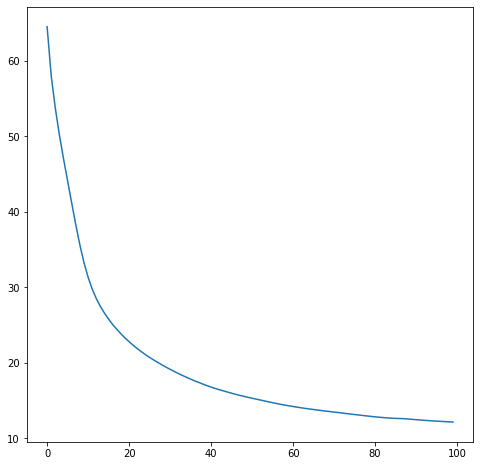

In [434]:
from tqdm.notebook import tqdm
n_epochs = 100
if torch.cuda.is_available():
    net.cuda()
total_loss = []
net.train()
epoch_loss = 0
for epoch in tqdm( range(n_epochs) ):
    print("current epoch is:",epoch)
    epoch_loss = 0
    for x in train_loader:
        mse_loss = 0
        if torch.cuda.is_available():
            x = x.cuda()
            #print(x.shape)
        optimizer.zero_grad()
        prediction = net(x)
        mse_loss = loss_func(prediction, x) # <-- note that i'm using the input as the target
        epoch_loss = epoch_loss + mse_loss.item()
        mse_loss.backward()
        optimizer.step()
        
    clear_output(wait=True)
    total_loss.append(epoch_loss)
    print('Loss Per epoch: ',epoch_loss)

import matplotlib.pyplot as plt
plt.plot(total_loss)

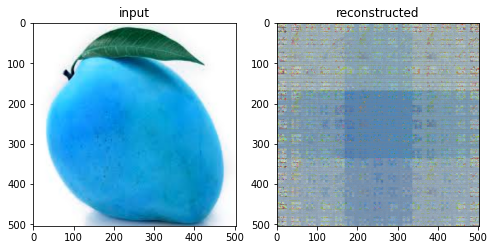

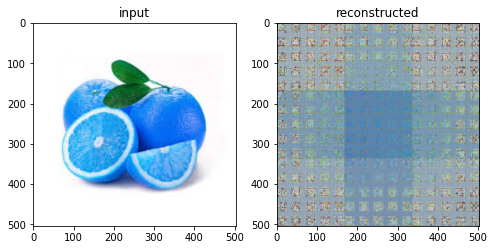

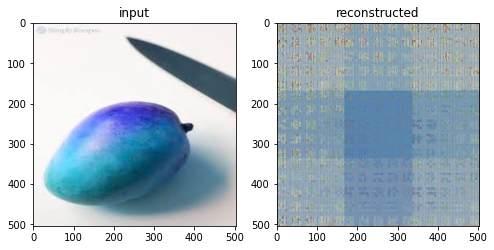

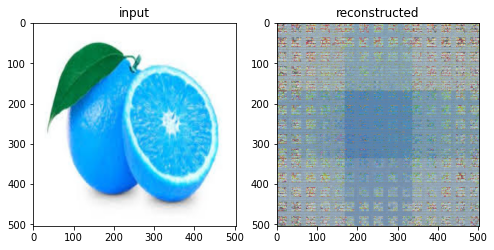

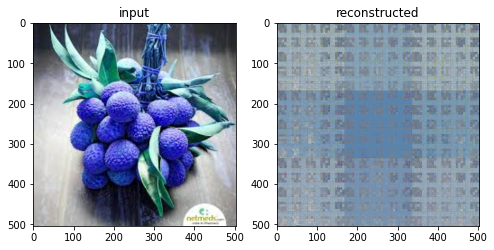

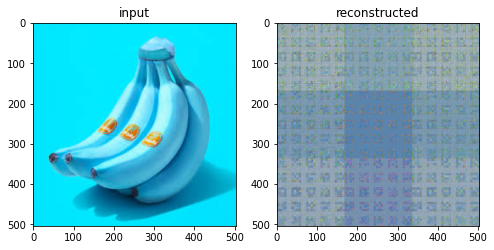

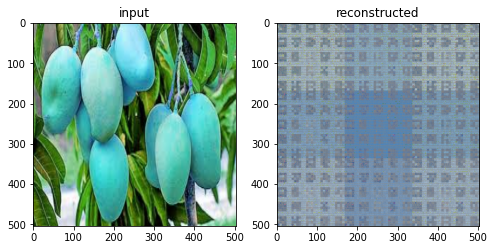

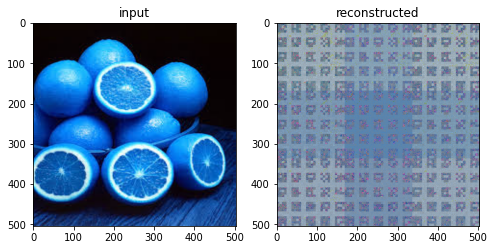

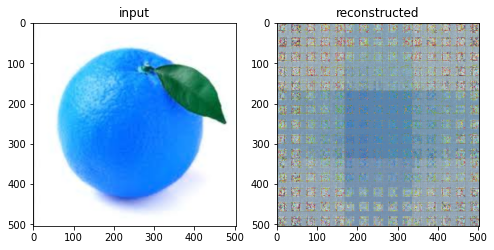

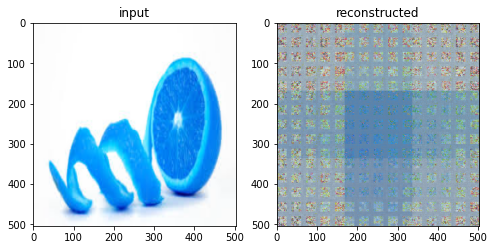

In [444]:
import matplotlib.pyplot as plt

net.cpu()
net.eval()
counter = 0
for x in train_loader:
    counter = counter + 1
    fig,ax = plt.subplots(1,2,figsize=(8,4))
    ax[0].set_title('input')
    ax[1].set_title('reconstructed')
    prediction = net(x)
    x = torch.reshape(x,(504,504,3))
    #print(x.shape)
    #print(x)
    ax[0].imshow((x.detach().numpy()*255).astype('uint8'))
    prediction = torch.reshape(prediction,(504,504,3))
    #prediction = prediction.view(504,504,3)
    #print(prediction.shape)
    #print(prediction)
    ax[1].imshow((prediction.detach().numpy()*255).astype('uint8'))
    plt.show()
    if(counter==10):
      break

In [ ]:
net.enc2.weight.shape